In [35]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from tqdm.notebook import tqdm

from IPython.core.debugger import set_trace

In [36]:
class Normalize(object):
    def __call__(self, sample):
        return (2 * (sample - sample.min()) / (sample.max() - sample.min()) - 1)

In [37]:
def get_dataloader(batch_size):
    
    transforms = T.Compose([
        T.ToTensor(),
        Normalize(),
    ])

    dataset = MNIST('./data', download=True, transform=transforms)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

def sample_noise(latent_len, batch_size, device):
    out = []
    for i in range(batch_size):
        out.append(torch.normal(mean=torch.zeros(latent_len), std=torch.ones(latent_len)))
    return torch.stack(out).to(device)

In [38]:
def discriminator_loss(pred, target):
    criterion = nn.BCELoss()
    loss = criterion(pred.flatten(), target)
    return loss

def generator_loss(pred, device):
    criterion = nn.BCELoss()
    loss = criterion(pred.flatten(), torch.ones(pred.flatten().shape).to(device))
    return loss

In [45]:
class Generator(nn.Module):
    def __init__(self, latent_len):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(in_features=latent_len, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=28*28)
        self.act = nn.LeakyReLU(0.2)        
        
    def forward(self, z):
        z = self.fc1(z)
        z = self.act(z)
        z = self.fc2(z)
        return z.tanh()

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=1)
        
        self.act = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x).sigmoid()
        return x

In [58]:
def train_gan(hp):
    
    print ("Using device", hp['device'])
    
    ## Models
    G = Generator(hp["latent_len"])
    D = Discriminator()
    
    G.to(hp['device'])
    D.to(hp['device'])
    
    G.load_state_dict(torch.load('checkpoints/generator.pt'))
    D.load_state_dict(torch.load('checkpoints/discriminator.pt'))
    
    # Optimizer
    optimizer_G = optim.Adam(G.parameters(), lr=hp["lr"])
    optimizer_D = optim.Adam(D.parameters(), lr=hp["lr"])
    
    optimizer_G.load_state_dict(torch.load('checkpoints/optim_G.pt'))
    optimizer_D.load_state_dict(torch.load('checkpoints/optim_D.pt'))
    
    # Data
    data_loader = get_dataloader(hp["batch_size"])
    
    # Train
    for epoch in range(hp["epochs"]):
        print("\n#### Epoch ", epoch + 1)
        running_loss_D = []
        running_loss_G = []
        
        for batch in tqdm(data_loader):
            # Minibatch
            x, _ = batch
            x = x.to(hp['device'])
            hp['batch_size'] = len(x) # This solves issue where last batch is smaller than specified batch size
            
            #########################
            ## Train Discriminator ##
            #########################
            
            ## Prep
            D.train(); G.eval();
            z = sample_noise(hp['latent_len'], hp['batch_size'], hp['device'])
            gen = G(z)
            
            ## Pred
            batch = torch.cat([x.reshape([hp['batch_size'], 28*28]), gen])
            targets = torch.cat([torch.ones(hp['batch_size']), torch.zeros(hp['batch_size'])])
            targets = targets.to(hp['device'])
            
            ## Loss
            preds = D(batch)
            loss_D = torch.mean(discriminator_loss(preds, targets))
            running_loss_D.append(loss_D.item())
            
            # Backprop
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

            #####################
            ## Train Generator ##
            #####################
            
            ## Prep
            D.eval(); G.train();
            z = sample_noise(hp['latent_len'], hp['batch_size'], hp['device'])
            
            ## Pred
            gen = G(z)
            preds = D(gen)
            
            ## Loss
            loss_G = torch.mean(generator_loss(preds, hp['device']))
            running_loss_G.append(loss_G.item())
            
            # Backprop
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()
        
        print('Loss_D:', np.mean(running_loss_D))
        print('Loss_G:', np.mean(running_loss_G))
        
    torch.save(G.state_dict(), 'checkpoints/generator.pt')
    torch.save(D.state_dict(), 'checkpoints/discriminator.pt')
    torch.save(optimizer_G.state_dict(), 'checkpoints/optim_G.pt')
    torch.save(optimizer_D.state_dict(), 'checkpoints/optim_D.pt')

In [59]:
def visualize_output(hp):  
    # Sample noise vector z
    z = sample_noise(hp['latent_len'], hp['batch_size'], hp['device'])
    
    # Load trained generator
    G = Generator(hp['latent_len'])
    G.load_state_dict(torch.load('checkpoints/generator.pt'))
    G.eval()
    G.to(hp['device'])
    
    # Generate image
    sample = G(z)
    output = sample.cpu().detach().numpy()

    # Display
    fig=plt.figure(figsize=(20, 8))
    columns = 8
    rows = 4
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(output[i-1, :].reshape([28,28]), cmap='gray')
    plt.show()

In [67]:
hp = {
    'epochs': 100,
    'latent_len': 100,
    'batch_size': 256,
    'lr': 3e-4,
    'device': torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
}

In [68]:
train_gan(hp)

Using device cuda:0

#### Epoch  1



Loss_D: 0.521579339656424
Loss_G: 1.3120369890902905

#### Epoch  2



Loss_D: 0.5344638664671715
Loss_G: 1.2724648107873633

#### Epoch  3



Loss_D: 0.5287346784104692
Loss_G: 1.3072590368859311

#### Epoch  4



Loss_D: 0.5230157866122874
Loss_G: 1.3369420931694356

#### Epoch  5



Loss_D: 0.520581258231021
Loss_G: 1.3325469701848132

#### Epoch  6



Loss_D: 0.5274794393397392
Loss_G: 1.2701472797292344

#### Epoch  7



Loss_D: 0.5352741673905799
Loss_G: 1.2551912756676369

#### Epoch  8



Loss_D: 0.5345281900243556
Loss_G: 1.276613892646546

#### Epoch  9



Loss_D: 0.5241888793224984
Loss_G: 1.3324208865774438

#### Epoch  10



Loss_D: 0.5163872135446427
Loss_G: 1.3416698767783795

#### Epoch  11



Loss_D: 0.5324059620816657
Loss_G: 1.2621771967157405

#### Epoch  12



Loss_D: 0.5272478877229894
Loss_G: 1.263562551711468

#### Epoch  13



Loss_D: 0.5199674957610191
Loss_G: 1.344698121953518

#### Epoch  14



Loss_D: 0.5191537211550042
Loss_G: 1.363570241978828

#### Epoch  15



Loss_D: 0.5176073081949923
Loss_G: 1.3356941060816987

#### Epoch  16



Loss_D: 0.521367495617968
Loss_G: 1.306370959383376

#### Epoch  17



Loss_D: 0.527386295288167
Loss_G: 1.30046370460632

#### Epoch  18



Loss_D: 0.5212211622836742
Loss_G: 1.3320090484111866

#### Epoch  19



Loss_D: 0.5226013706085529
Loss_G: 1.3148088528754864

#### Epoch  20



Loss_D: 0.5250540411218684
Loss_G: 1.3084254761959644

#### Epoch  21



Loss_D: 0.5293389135218681
Loss_G: 1.3000032947418538

#### Epoch  22



Loss_D: 0.5333482980728149
Loss_G: 1.2696576440587957

#### Epoch  23



Loss_D: 0.5308817198935976
Loss_G: 1.2787214697675502

#### Epoch  24



Loss_D: 0.533167312627143
Loss_G: 1.2634743786872702

#### Epoch  25



Loss_D: 0.5322714815748498
Loss_G: 1.2778367816133702

#### Epoch  26



Loss_D: 0.5332564875166467
Loss_G: 1.2676672676776317

#### Epoch  27



Loss_D: 0.5294617182396828
Loss_G: 1.277769517391286

#### Epoch  28



Loss_D: 0.5334514590019875
Loss_G: 1.2773706464057273

#### Epoch  29



Loss_D: 0.526814444775277
Loss_G: 1.2900162235219428

#### Epoch  30



Loss_D: 0.5276526532274611
Loss_G: 1.2860862257632804

#### Epoch  31



Loss_D: 0.5303268218294103
Loss_G: 1.2743794357523006

#### Epoch  32



Loss_D: 0.5312112355485875
Loss_G: 1.2651924282946485

#### Epoch  33



Loss_D: 0.5343680040633425
Loss_G: 1.2593400803018124

#### Epoch  34



Loss_D: 0.525415944545827
Loss_G: 1.2990939792166365

#### Epoch  35



Loss_D: 0.5238949609563706
Loss_G: 1.3041431492947517

#### Epoch  36



Loss_D: 0.5327695458493334
Loss_G: 1.2994643297601254

#### Epoch  37



Loss_D: 0.5114753707926324
Loss_G: 1.371825718626063

#### Epoch  38



Loss_D: 0.5146404414734942
Loss_G: 1.3640295322905196

#### Epoch  39



Loss_D: 0.5220466237118904
Loss_G: 1.2982986457804415

#### Epoch  40



Loss_D: 0.5366778324259088
Loss_G: 1.2590086865932384

#### Epoch  41



Loss_D: 0.5261941984612891
Loss_G: 1.276484788478689

#### Epoch  42



Loss_D: 0.5203590114065941
Loss_G: 1.3184195718866714

#### Epoch  43



Loss_D: 0.5291139156260389
Loss_G: 1.302173913793361

#### Epoch  44



Loss_D: 0.5271584844335596
Loss_G: 1.295173467220144

#### Epoch  45



Loss_D: 0.5277689018148057
Loss_G: 1.3032768896285525

#### Epoch  46



Loss_D: 0.5199407734769456
Loss_G: 1.3250347003023675

#### Epoch  47



Loss_D: 0.5195228940628944
Loss_G: 1.3106717928926996

#### Epoch  48



Loss_D: 0.5205176765614368
Loss_G: 1.325120669983803

#### Epoch  49



Loss_D: 0.5331915466075248
Loss_G: 1.2788721036403736

#### Epoch  50



Loss_D: 0.5284508164892805
Loss_G: 1.2853839014438873

#### Epoch  51



Loss_D: 0.5318085466293578
Loss_G: 1.3099805390581172

#### Epoch  52



Loss_D: 0.5230296052516775
Loss_G: 1.2834177719785813

#### Epoch  53



Loss_D: 0.5333830016724607
Loss_G: 1.2615330018895738

#### Epoch  54



Loss_D: 0.5373647821710464
Loss_G: 1.2690514995696698

#### Epoch  55



Loss_D: 0.525264583749974
Loss_G: 1.3039367835572426

#### Epoch  56



Loss_D: 0.5327500837914487
Loss_G: 1.2780729567750972

#### Epoch  57



Loss_D: 0.5327455359570523
Loss_G: 1.278727607777778

#### Epoch  58



Loss_D: 0.5335695806969988
Loss_G: 1.2722603397166474

#### Epoch  59



Loss_D: 0.5340561351877577
Loss_G: 1.2652704971901914

#### Epoch  60



Loss_D: 0.5272661901534872
Loss_G: 1.2941039009297148

#### Epoch  61



Loss_D: 0.5270358807228981
Loss_G: 1.281907809034307

#### Epoch  62



Loss_D: 0.5311472391828578
Loss_G: 1.2652983995194131

#### Epoch  63



Loss_D: 0.5359527267040091
Loss_G: 1.2612242947233485

#### Epoch  64



Loss_D: 0.5284670256553812
Loss_G: 1.2612729846163

#### Epoch  65



Loss_D: 0.5284462214784419
Loss_G: 1.2856770170495866

#### Epoch  66



Loss_D: 0.5250457782694634
Loss_G: 1.2949471813567142

#### Epoch  67



Loss_D: 0.5263947450100107
Loss_G: 1.2782587936583987

#### Epoch  68



Loss_D: 0.5265835991565218
Loss_G: 1.2918989463055388

#### Epoch  69



Loss_D: 0.5215362310409546
Loss_G: 1.3268635973017266

#### Epoch  70



Loss_D: 0.5273080319800275
Loss_G: 1.2954725062593502

#### Epoch  71



Loss_D: 0.5252218918597444
Loss_G: 1.3159372301811867

#### Epoch  72



Loss_D: 0.5200225000685834
Loss_G: 1.3236863075418674

#### Epoch  73



Loss_D: 0.5249012352304255
Loss_G: 1.3026964623877342

#### Epoch  74



Loss_D: 0.5300622209589532
Loss_G: 1.2834184846979506

#### Epoch  75



Loss_D: 0.5281039267144305
Loss_G: 1.296195213338162

#### Epoch  76



Loss_D: 0.5221068025903499
Loss_G: 1.313939109000754

#### Epoch  77



Loss_D: 0.5222787321882045
Loss_G: 1.3143499064952768

#### Epoch  78



Loss_D: 0.5285560994706255
Loss_G: 1.291943492280676

#### Epoch  79



Loss_D: 0.5302599539148046
Loss_G: 1.2890685910874224

#### Epoch  80



Loss_D: 0.5285270999086664
Loss_G: 1.280560357266284

#### Epoch  81



Loss_D: 0.5307961533678339
Loss_G: 1.2746361136436462

#### Epoch  82



Loss_D: 0.5186157419326457
Loss_G: 1.2928442686162096

#### Epoch  83



Loss_D: 0.5254731085706265
Loss_G: 1.2855023546421782

#### Epoch  84



Loss_D: 0.5330534360510237
Loss_G: 1.271693170324285

#### Epoch  85



Loss_D: 0.5288417854207628
Loss_G: 1.2924883172867145

#### Epoch  86



Loss_D: 0.5257594388850192
Loss_G: 1.3021212910084015

#### Epoch  87



Loss_D: 0.5294975422798319
Loss_G: 1.2805191311430424

#### Epoch  88



Loss_D: 0.5276599884033203
Loss_G: 1.283693133009241

#### Epoch  89



Loss_D: 0.5275102838556818
Loss_G: 1.2798782356241916

#### Epoch  90



Loss_D: 0.5322358159308738
Loss_G: 1.277696027147009

#### Epoch  91



Loss_D: 0.5274685773443668
Loss_G: 1.281530389126311

#### Epoch  92



Loss_D: 0.53342463285365
Loss_G: 1.2759548821347826

#### Epoch  93



Loss_D: 0.527211949419468
Loss_G: 1.29585055645476

#### Epoch  94



Loss_D: 0.5264325129224899
Loss_G: 1.2998906756969208

#### Epoch  95



Loss_D: 0.5250559426368551
Loss_G: 1.293564036805579

#### Epoch  96



Loss_D: 0.5312782254624874
Loss_G: 1.2733425076971663

#### Epoch  97



Loss_D: 0.5280715910678214
Loss_G: 1.2837887916159123

#### Epoch  98



Loss_D: 0.5367102857599867
Loss_G: 1.2683522490744894

#### Epoch  99



Loss_D: 0.5273141275060937
Loss_G: 1.270450876367853

#### Epoch  100



Loss_D: 0.5284303202273998
Loss_G: 1.280953892241133


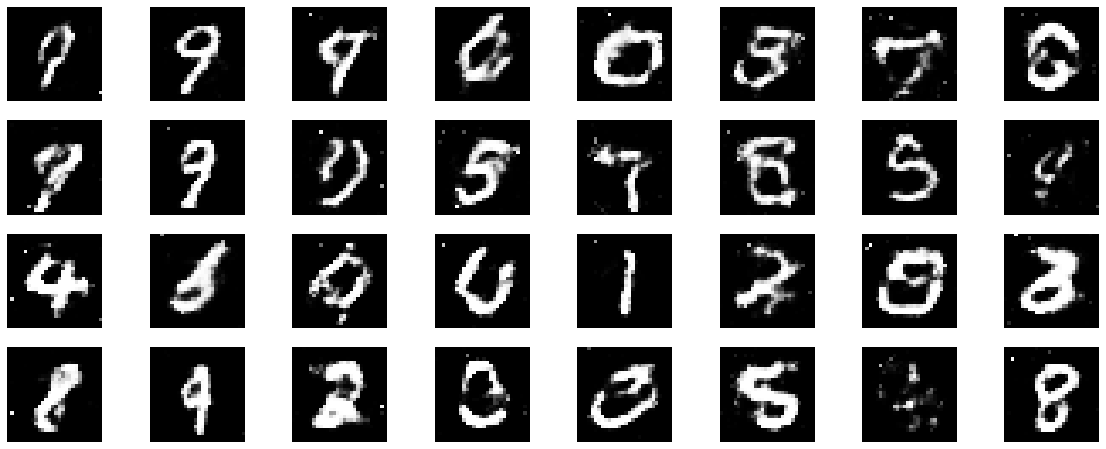

In [70]:
visualize_output(hp) ## 200

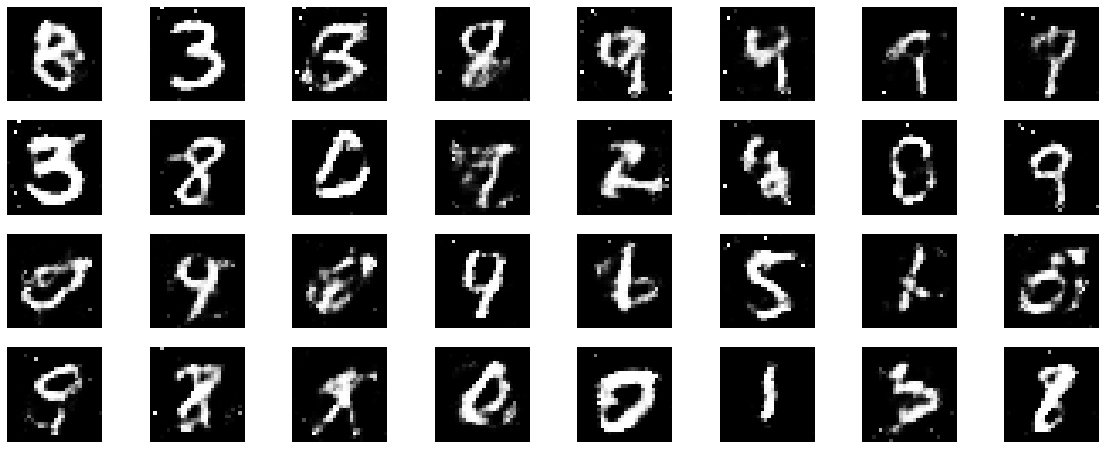

In [71]:
visualize_output(hp) ## 200

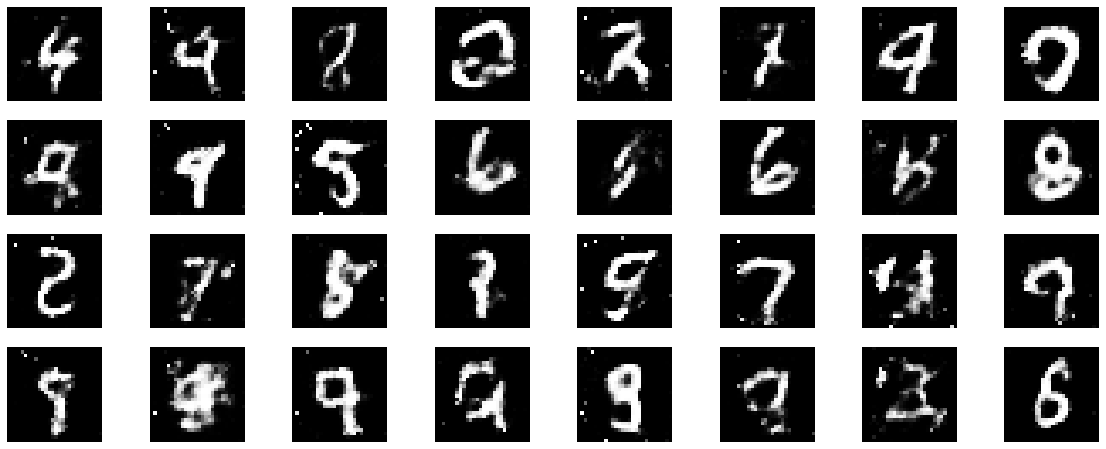

In [72]:
visualize_output(hp) ## 200

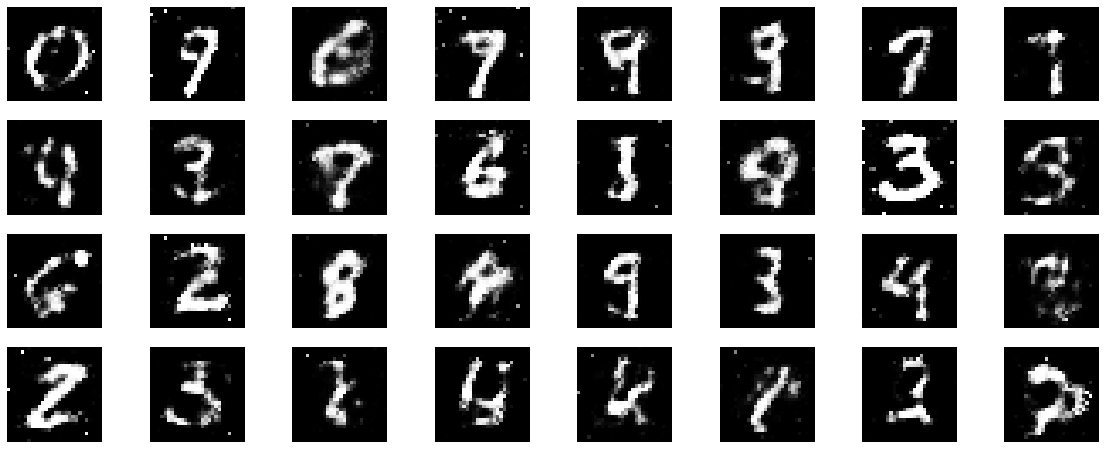

In [63]:
visualize_output(hp) ## 100

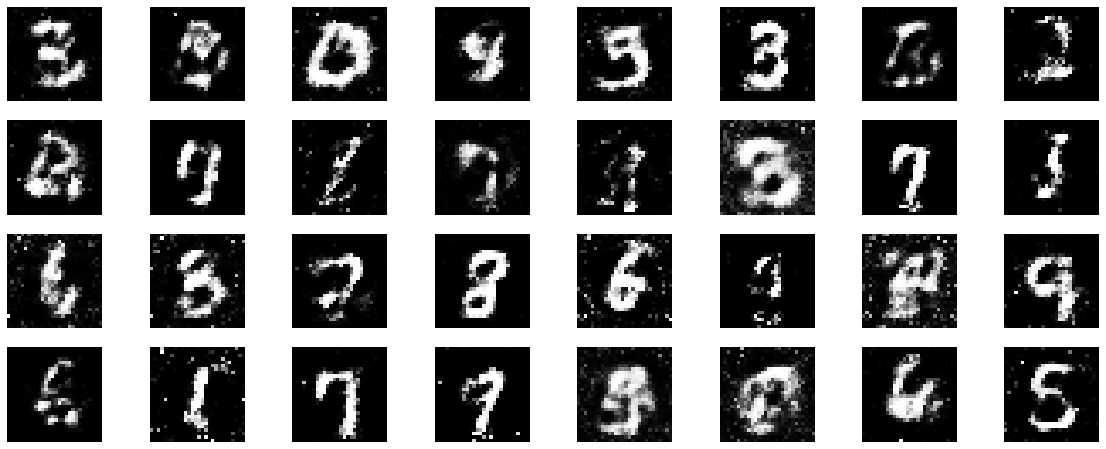

In [54]:
visualize_output(hp) ## 50